<a href="https://colab.research.google.com/github/quangly/MovieRecommendation/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Description: Build a movie recommendation engine using Python

In [104]:
# Import the libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

from pprint import pprint as pp

import pickle

In [20]:
#Load the data
from google.colab import files
uploaded = files.upload()

In [142]:
#source https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
df = pd.read_csv("imdb_top_1000.csv")
df['Movie_id'] = range(0,1000)
# shift column 'Name' to first position
first_column = df.pop('Movie_id')
  
# insert column using insert(position,column_name,
# first_column) function
df.insert(0, 'Movie_id', first_column)
#rename column Category to Genre
df = df.rename(columns={"Category": "Genre"})
df = df.rename(columns={"Series_Title": "Title"})
df.head(3)



,Movie_id,Poster_Link,Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


In [5]:
#get count of numbr of row/smovies in the data set and number of columns
df.shape

(1000, 17)

In [6]:
#create list of important columns for the recommendation engine
columns = ['Director', 'Star1','Star2','Star3','Star4','Genre','Title']

In [143]:
#show the data
df[columns].head(3)

,Director,Star1,Star2,Star3,Star4,Genre,Title
0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Drama,The Shawshank Redemption
1,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"Crime, Drama",The Godfather
2,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"Action, Crime, Drama",The Dark Knight


In [146]:
#check for any missing values in the import columns
df[columns].isnull().values.any()
df.columns[df.isna().any()].tolist()
# df.loc[:, df.isnull().any()]

['Certificate', 'Meta_score', 'Gross']

In [157]:
# create a function to combine the values of the import columns into a single string
def get_important_features(df):
  important_features = []
  for i in range(0,df.shape[0]):
    important_features.append(df['Star1'][i] + \
                              ' ' + df['Star2'][i] + \
                              ' ' + df['Star3'][i] + \
                              ' ' + df['Star4'][i] + \
                              ' ' + df['Director'][i] + \
                              ' ' + df['Title'][i] + \
                              ' ' + df['Genre'][i])
  
  return important_features

In [158]:
#create a column to hold the combined strings
df['important_features'] = get_important_features(df)
# #show the data
# pd.set_option('display.max_rows', None)
# # df['important_features'].unique()
# df.head(3)

In [159]:
# convert the text to a matrix of token counts
# https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c
cm = CountVectorizer().fit_transform(df['important_features'])

In [160]:
#get the cosine simimlarity matrix from the count matrix
cs = cosine_similarity(cm)
#Print the cosine similarity matrix - values 0 to 1. 1 = 100% similar to a movie
#each row is a movie and each column is a movie.
#first row/column is 1 b/c it's a movie similar to itself
# print(cs)
#get the shape of the cosine similarity matrix
# cs.shape

In [161]:
#create a list of enumerations for the similarity score [(movie_id, similarity score), (..)]
def get_movie_scores(movie_id):
  scores = list(enumerate(cs[movie_id]))
  #Sort the list x[1] = similarity score descending score
  sorted_scores = sorted(scores, key = lambda x:x[1], reverse = True)
  #get every element exempt first element
  sorted_scores = sorted_scores[1:]
  return sorted_scores

#get list of unique movie id
movie_ids = df['Movie_id'].unique().tolist()
movie_score_list = []
for movie_id in movie_ids:
  movie_score_list.append({"movie_id": movie_id,
                           "sorted_scores": get_movie_scores(movie_id)})


# create model that includes dataframe and movie_score_list
model = dict()
model["df"] = df
model["movie_score_list"] = movie_score_list

In [162]:
# export using pickle
with open('model_movie_score_list.pkl', 'wb') as fid:
     pickle.dump(model, fid)

In [166]:
# Read the data from the pickled file
with open('model_movie_score_list.pkl', 'rb') as fid:
     model_movie_score_list = pickle.load(fid)


In [167]:
#get list of unique movie names
df = model_movie_score_list["df"]
movie_score_list = model_movie_score_list["movie_score_list"]
print(list(df['Title'].unique()))

['The Shawshank Redemption', 'The Godfather', 'The Dark Knight', 'The Godfather: Part II', '12 Angry Men', 'The Lord of the Rings: The Return of the King', 'Pulp Fiction', "Schindler's List", 'Inception', 'Fight Club', 'The Lord of the Rings: The Fellowship of the Ring', 'Forrest Gump', 'Il buono, il brutto, il cattivo', 'The Lord of the Rings: The Two Towers', 'The Matrix', 'Goodfellas', 'Star Wars: Episode V - The Empire Strikes Back', "One Flew Over the Cuckoo's Nest", 'Hamilton', 'Gisaengchung', 'Soorarai Pottru', 'Interstellar', 'Cidade de Deus', 'Sen to Chihiro no kamikakushi', 'Saving Private Ryan', 'The Green Mile', 'La vita è bella', 'Se7en', 'The Silence of the Lambs', 'Star Wars', 'Seppuku', 'Shichinin no samurai', "It's a Wonderful Life", 'Joker', 'Whiplash', 'The Intouchables', 'The Prestige', 'The Departed', 'The Pianist', 'Gladiator', 'American History X', 'The Usual Suspects', 'Léon', 'The Lion King', 'Terminator 2: Judgment Day', 'Nuovo Cinema Paradiso', 'Hotaru no hak

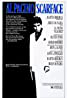

Scarface None 

The 7 most recommended movies to Scarface are:

********************




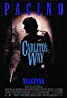

1: Carlito's Way None A Puerto Rican former convict, just released from prison, pledges to stay away from drugs and violence despite the pressure around him and lead on to a better life outside of N.Y.C.




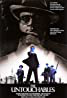

2: The Untouchables None During the era of Prohibition in the United States, Federal Agent Eliot Ness sets out to stop ruthless Chicago gangster Al Capone and, because of rampant corruption, assembles a small, hand-picked team to help him.




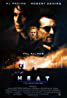

3: Heat None A group of professional bank robbers start to feel the heat from police when they unknowingly leave a clue at their latest heist.




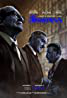

4: The Irishman None An old man recalls his time painting houses for his friend, Jimmy Hoffa, through the 1950-70s.




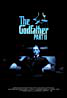

5: The Godfather: Part II None The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate.




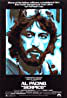

6: Serpico None An honest New York cop named Frank Serpico blows the whistle on rampant corruption in the force only to have his comrades turn against him.




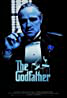

7: The Godfather None An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.




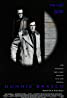

8: Donnie Brasco None An FBI undercover agent infiltrates the mob and finds himself identifying more with the mafia life, at the expense of his regular one.




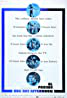

9: Dog Day Afternoon None Three amateur bank robbers plan to hold up a bank. A nice simple robbery: Walk in, take the money, and run. Unfortunately, the supposedly uncomplicated heist suddenly becomes a bizarre nightmare as everything that could go wrong does.




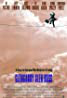

10: Glengarry Glen Ross None An examination of the machinations behind the scenes at a real estate office.


In [169]:
#get the title of the movie that user likes
# "The Dark Knight" "Scarface" "Pulp Fiction" "Inception" "The Silence of the Lambs" The Hangover
title = "Scarface"
#find the movies id
movie_id = df[df.Title == title]['Movie_id'].values[0]
movie_title = df[df.Movie_id == movie_id]['Title'].values[0]
poster_url = df[df.Movie_id == movie_id]['Poster_Link'].values[0]
image = io.imread(poster_url) 
print(movie_title, cv2_imshow(image), '')

print('\nThe 7 most recommended movies to', title, 'are:\n')
print('*'*20)

#get sorted scores based on movie_id from trained movie_score_list
sorted_scores = next(item["sorted_scores"] for item in movie_score_list if item["movie_id"] == movie_id)

j = 0
for item in sorted_scores[:10]:
  movie_title = df[df.Movie_id == item[0]]['Title'].values[0]
  poster_url = df[df.Movie_id == item[0]]['Poster_Link'].values[0]
  overview = df[df.Movie_id == item[0]]['Overview'].values[0]
  image = io.imread(poster_url)
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat((image, image_2))

  print('\n')
  print(str(j+1) + ':', movie_title, cv2_imshow(image), overview)
  j = j+1
